# Code for Replication in Python - csdid
This notebook mirrors the R/Stata appendix in JEL-DiD using csdid.
It generates tables, figures, and a self-contained HTML report.

In [ ]:
"""Code for Replication in Python.

This script mirrors the R/Stata appendix in JEL-DiD using csdid.
It generates tables, figures, and a self-contained HTML report.
"""

from __future__ import annotations

import base64
import html as html_lib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm

from csdid.att_gt import ATTgt
from csdid import _version as csdid_version

SHOW_OUTPUTS = "__file__" not in globals()
if SHOW_OUTPUTS:
    from IPython.display import display, HTML

## Configuration

In [ ]:
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd().resolve()
DATA_PATH = ROOT / "data" / "county_mortality_data.csv"
TABLE_DIR = ROOT / "tables"
FIG_DIR = ROOT / "figures"
HTML_PATH = ROOT / "python.html"

SEED = 20240924
BITERS = 25000
BOOTSTRAP = True

COVS = [
    "perc_female",
    "perc_white",
    "perc_hispanic",
    "unemp_rate",
    "poverty_rate",
    "median_income",
]

np.random.seed(SEED)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Missing data file: {DATA_PATH}")

## Helpers (minimal)

In [ ]:
def weighted_mean(values: pd.Series, weights: pd.Series) -> float:
    values = np.asarray(values, dtype=float)
    weights = np.asarray(weights, dtype=float)
    return float(np.average(values, weights=weights))


def weighted_var(values: pd.Series, weights: pd.Series) -> float:
    values = np.asarray(values, dtype=float)
    weights = np.asarray(weights, dtype=float)
    avg = np.average(values, weights=weights)
    var = np.average((values - avg) ** 2, weights=weights)
    if weights.sum() > 1:
        var *= weights.sum() / (weights.sum() - 1)
    return float(var)


def fit_ols(formula: str, data: pd.DataFrame, weights=None, cluster: str | None = None):
    model = smf.wls(formula, data=data, weights=weights) if weights is not None else smf.ols(formula, data=data)
    result = model.fit()
    if cluster is not None:
        result = result.get_robustcov_results(cov_type="cluster", groups=data[cluster])
    return result


def fit_logit(formula: str, data: pd.DataFrame, weights=None, cluster: str | None = None):
    model = smf.glm(formula, data=data, family=sm.families.Binomial(), freq_weights=weights)
    if cluster is not None:
        return model.fit(cov_type="cluster", cov_kwds={"groups": data[cluster]})
    return model.fit()


def get_param(result, name: str):
    names = list(result.model.exog_names)
    params = dict(zip(names, np.asarray(result.params).tolist()))
    ses = dict(zip(names, np.asarray(result.bse).tolist()))
    return params.get(name), ses.get(name)


def format_estimate_se(value, se, digits: int) -> str:
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return ""
    if se is None or (isinstance(se, float) and np.isnan(se)):
        return f"{value:.{digits}f}"
    return f"{value:.{digits}f}<br><span class=\"se\">({se:.{digits}f})</span>"


def df_to_html_table(df: pd.DataFrame) -> str:
    return df.to_html(index=False, escape=False, classes="data")


def display_table(df: pd.DataFrame) -> None:
    if SHOW_OUTPUTS:
        display(HTML(df_to_html_table(df)))


def save_fig(fig: plt.Figure, name: str) -> Path:
    path = FIG_DIR / name
    fig.savefig(path, dpi=180, bbox_inches="tight")
    plt.close(fig)
    return path


def encode_fig(path: Path) -> str:
    with open(path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode("ascii")
    return f"data:image/png;base64,{encoded}"


def extract_block(text: str, label: str) -> str:
    start = f"# --- BEGIN {label}"
    end = f"# --- END {label}"
    start_idx = text.find(start)
    end_idx = text.find(end)
    if start_idx == -1 or end_idx == -1:
        return ""
    block = text[start_idx + len(start):end_idx]
    return block.strip("\n")


def section_html(section_id: str, title: str, description: str, body_html: str, code: str) -> str:
    tag = section_id.replace("table", "Table ").replace("figure", "Figure ").title()
    code_html = html_lib.escape(code)
    return f"""
<section id="{section_id}">
  <span class="tag">{tag}</span>
  <h2>{title}</h2>
  <p>{description}</p>
  <div class="code-block">
    <pre><code>{code_html}</code></pre>
  </div>
  <div class="output">{body_html}</div>
</section>
"""

## Load data

In [ ]:
df = pd.read_csv(DATA_PATH)
df["state"] = df["county"].str[-2:]
df["yaca"] = pd.to_numeric(df["yaca"], errors="coerce")

## Table 1: Medicaid Expansion Adoption

In [ ]:
# --- BEGIN TABLE 1

table1_data = df.copy()
table1_data = table1_data[table1_data["state"] != "DC"].copy()

table1_data["adopt"] = np.where(
    table1_data["yaca"].isna(),
    "Non-Expansion",
    np.where(
        table1_data["state"].isin(["DE", "MA", "NY", "VT"]),
        "Pre-2014",
        table1_data["yaca"].astype("Int64").astype(str),
    ),
)

adopts = table1_data[["state", "adopt"]].drop_duplicates().sort_values("state")

states = (
    adopts.groupby("adopt")["state"]
    .apply(lambda s: ", ".join(s))
    .reset_index(name="states")
)
states["state_share"] = adopts.groupby("adopt")["state"].size().values / 50

base_2013 = table1_data[table1_data["year"] == 2013]
total_counties = len(base_2013)
total_pop = base_2013["population_20_64"].sum()

counties_pop = (
    base_2013.groupby("adopt")
    .agg(county_share=("county_code", "size"), pop_share=("population_20_64", "sum"))
    .reset_index()
)
counties_pop["county_share"] = counties_pop["county_share"] / total_counties
counties_pop["pop_share"] = counties_pop["pop_share"] / total_pop

table1 = states.merge(counties_pop, on="adopt", how="left")
order = ["Pre-2014", "2014", "2015", "2016", "2019", "2020", "2021", "2023", "Non-Expansion"]
table1["order"] = table1["adopt"].apply(lambda x: order.index(x) if x in order else len(order))
table1 = table1.sort_values("order").drop(columns=["order"]).reset_index(drop=True)

table1["state_share"] = table1["state_share"].map(lambda x: f"{x:.2f}")
table1["county_share"] = table1["county_share"].map(lambda x: f"{x:.2f}")
table1["pop_share"] = table1["pop_share"].map(lambda x: f"{x:.2f}")

table1 = table1.rename(
    columns={
        "adopt": "Expansion Year",
        "states": "States",
        "state_share": "Share of States",
        "county_share": "Share of Counties",
        "pop_share": "Share of Adults (2013)",
    }
)

table1.to_csv(TABLE_DIR / "table1_adoptions.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table1)

# --- END TABLE 1

Expansion Year,States,Share of States,Share of Counties,Share of Adults (2013)
Pre-2014,"DE, MA, NY, VT",0.08,0.03,0.09
2014,"AR, AZ, CA, CO, CT, HI, IA, IL, KY, MD, MI, MN, ND, NH, NJ, NM, NV, OH, OR, RI, WA, WV",0.44,0.36,0.45
2015,"AK, IN, PA",0.06,0.06,0.06
2016,"LA, MT",0.04,0.04,0.02
2019,"ME, VA",0.04,0.05,0.03
2020,"ID, NE, UT",0.06,0.04,0.02
2021,"MO, OK",0.04,0.06,0.03
2023,"NC, SD",0.04,0.05,0.03
Non-Expansion,"AL, FL, GA, KS, MS, SC, TN, TX, WI, WY",0.20,0.31,0.26


## Table 2: Simple 2x2 DiD

In [ ]:
# --- BEGIN TABLE 2

mydata = df.copy()
mydata = mydata[~mydata["state"].isin(["DC", "DE", "MA", "NY", "VT"])]
mydata = mydata[(mydata["yaca"] == 2014) | (mydata["yaca"].isna()) | (mydata["yaca"] > 2019)]

mydata = mydata.assign(
    perc_white=mydata["population_20_64_white"] / mydata["population_20_64"] * 100,
    perc_hispanic=mydata["population_20_64_hispanic"] / mydata["population_20_64"] * 100,
    perc_female=mydata["population_20_64_female"] / mydata["population_20_64"] * 100,
    unemp_rate=mydata["unemp_rate"] * 100,
    median_income=mydata["median_income"] / 1000,
)

keep_cols = [
    "state",
    "county",
    "county_code",
    "year",
    "population_20_64",
    "yaca",
    "crude_rate_20_64",
] + COVS

mydata = mydata[keep_cols].copy()
mydata = mydata.dropna(subset=COVS + ["crude_rate_20_64", "population_20_64"]).copy()

mydata = mydata.groupby("county_code", group_keys=False).filter(
    lambda g: g["year"].isin([2013, 2014]).sum() == 2
)
mydata = mydata.groupby("county_code", group_keys=False).filter(lambda g: len(g) == 11).reset_index(drop=True)

mydata["Treat"] = np.where((mydata["yaca"] == 2014) & (~mydata["yaca"].isna()), 1, 0)
mydata["Post"] = np.where(mydata["year"] >= 2014, 1, 0)

weights = (
    mydata[mydata["year"] == 2013][["county_code", "population_20_64"]]
    .drop_duplicates()
    .rename(columns={"population_20_64": "set_wt"})
)
mydata = mydata.merge(weights, on="county_code", how="left")

short_data = mydata[mydata["year"].isin([2013, 2014])].copy()
short_data["Post"] = np.where(short_data["year"] == 2014, 1, 0)

T_pre = short_data.loc[(short_data["Treat"] == 1) & (short_data["year"] == 2013), "crude_rate_20_64"].mean()
C_pre = short_data.loc[(short_data["Treat"] == 0) & (short_data["year"] == 2013), "crude_rate_20_64"].mean()
T_post = short_data.loc[(short_data["Treat"] == 1) & (short_data["year"] == 2014), "crude_rate_20_64"].mean()
C_post = short_data.loc[(short_data["Treat"] == 0) & (short_data["year"] == 2014), "crude_rate_20_64"].mean()

T_pre_w = weighted_mean(
    short_data.loc[(short_data["Treat"] == 1) & (short_data["year"] == 2013), "crude_rate_20_64"],
    short_data.loc[(short_data["Treat"] == 1) & (short_data["year"] == 2013), "set_wt"],
)
C_pre_w = weighted_mean(
    short_data.loc[(short_data["Treat"] == 0) & (short_data["year"] == 2013), "crude_rate_20_64"],
    short_data.loc[(short_data["Treat"] == 0) & (short_data["year"] == 2013), "set_wt"],
)
T_post_w = weighted_mean(
    short_data.loc[(short_data["Treat"] == 1) & (short_data["year"] == 2014), "crude_rate_20_64"],
    short_data.loc[(short_data["Treat"] == 1) & (short_data["year"] == 2014), "set_wt"],
)
C_post_w = weighted_mean(
    short_data.loc[(short_data["Treat"] == 0) & (short_data["year"] == 2014), "crude_rate_20_64"],
    short_data.loc[(short_data["Treat"] == 0) & (short_data["year"] == 2014), "set_wt"],
)

table2 = pd.DataFrame(
    [
        [
            "2013",
            f"{T_pre:.1f}",
            f"{C_pre:.1f}",
            f"{(T_pre - C_pre):.1f}",
            f"{T_pre_w:.1f}",
            f"{C_pre_w:.1f}",
            f"{(T_pre_w - C_pre_w):.1f}",
        ],
        [
            "2014",
            f"{T_post:.1f}",
            f"{C_post:.1f}",
            f"{(T_post - C_post):.1f}",
            f"{T_post_w:.1f}",
            f"{C_post_w:.1f}",
            f"{(T_post_w - C_post_w):.1f}",
        ],
        [
            "Trend/DiD",
            f"{(T_post - T_pre):.1f}",
            f"{(C_post - C_pre):.1f}",
            f"{((T_post - T_pre) - (C_post - C_pre)):.1f}",
            f"{(T_post_w - T_pre_w):.1f}",
            f"{(C_post_w - C_pre_w):.1f}",
            f"{((T_post_w - T_pre_w) - (C_post_w - C_pre_w)):.1f}",
        ],
    ],
    columns=["", "Expansion", "No Expansion", "Gap/DiD", "Expansion", "No Expansion", "Gap/DiD"],
)

table2.to_csv(TABLE_DIR / "table2_simple_did.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table2)

# --- END TABLE 2

,Expansion,No Expansion,Gap/DiD,Expansion,No Expansion,Gap/DiD
2013,419.2,474.0,-54.8,322.7,376.4,-53.7
2014,428.5,483.1,-54.7,326.5,382.7,-56.2
Trend/DiD,9.3,9.1,0.1,3.7,6.3,-2.6


## Table 3: Regression DiD

In [ ]:
# --- BEGIN TABLE 3

short_outcome = short_data.pivot(index="county_code", columns="year", values="crude_rate_20_64")
short_outcome = short_outcome.rename_axis(None, axis=1)
short_outcome_diff = (short_outcome[2014] - short_outcome[2013]).rename("diff")

county_base = (
    short_data.groupby("county_code")
    .agg(state=("state", "first"), set_wt=("set_wt", "mean"), Treat=("Treat", "mean"))
    .reset_index()
)
short_data2 = county_base.merge(short_outcome_diff, left_on="county_code", right_index=True, how="left")
short_data2["Post"] = 1

mod1 = fit_ols("crude_rate_20_64 ~ Treat * Post", short_data, cluster="county_code")
mod2 = fit_ols("crude_rate_20_64 ~ Treat:Post + C(county_code) + C(year)", short_data, cluster="county_code")
mod3 = fit_ols("diff ~ Treat", short_data2, cluster="county_code")

mod4 = fit_ols("crude_rate_20_64 ~ Treat * Post", short_data, weights=short_data["set_wt"], cluster="county_code")
mod5 = fit_ols(
    "crude_rate_20_64 ~ Treat:Post + C(county_code) + C(year)",
    short_data,
    weights=short_data["set_wt"],
    cluster="county_code",
)
mod6 = fit_ols("diff ~ Treat", short_data2, weights=short_data2["set_wt"], cluster="county_code")

models = [mod1, mod2, mod3, mod4, mod5, mod6]
model_labels = ["(1)", "(2)", "(3)", "(4)", "(5)", "(6)"]

rows = []
for coef, label in [
    ("Intercept", "Constant"),
    ("Treat", "Medicaid Expansion"),
    ("Post", "Post"),
    ("Treat:Post", "Medicaid Expansion x Post"),
]:
    row = [label]
    for m in models:
        val, se = get_param(m, coef)
        if coef == "Intercept" and val is None:
            val, se = get_param(m, "const")
        if coef == "Treat:Post" and val is None:
            val, se = get_param(m, "Treat")
        row.append(format_estimate_se(val, se, 1))
    rows.append(row)

fe_rows = [
    ["County fixed effects", "No", "Yes", "No", "No", "Yes", "No"],
    ["Year fixed effects", "No", "Yes", "No", "No", "Yes", "No"],
]

table3 = pd.DataFrame(rows, columns=["Variable"] + model_labels)
table3 = pd.concat([table3, pd.DataFrame(fe_rows, columns=table3.columns)], ignore_index=True)

table3.to_csv(TABLE_DIR / "table3_regression_did.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table3)

# --- END TABLE 3

Variable,(1),(2),(3),(4),(5),(6)
Constant,474.0(4.3),498.8(1.8),9.1(2.6),376.4(7.6),500.3(0.8),6.3(1.1)
Medicaid Expansion,-54.8(6.3),,0.1(3.7),-53.7(11.5),,-2.6(1.5)
Post,9.1(2.6),,,6.3(1.1),,
Medicaid Expansion x Post,0.1(3.7),0.1(5.3),0.1(3.7),-2.6(1.5),-2.6(2.1),-2.6(1.5)
County fixed effects,No,Yes,No,No,Yes,No
Year fixed effects,No,Yes,No,No,Yes,No


## Table 4: Covariate Balance

In [ ]:
# --- BEGIN TABLE 4

cov_2013 = short_data[short_data["year"] == 2013][["county_code", "Treat", "set_wt"] + COVS].copy()

unw_means = cov_2013.groupby("Treat")[COVS].mean()
unw_vars = cov_2013.groupby("Treat")[COVS].var()

unw_rows = []
for cov in COVS:
    mean0 = float(unw_means.loc[0, cov])
    mean1 = float(unw_means.loc[1, cov])
    var0 = float(unw_vars.loc[0, cov])
    var1 = float(unw_vars.loc[1, cov])
    norm_diff = (mean1 - mean0) / np.sqrt((var1 + var0) / 2)
    unw_rows.append([cov, mean0, mean1, norm_diff])

wtd_rows = []
for cov in COVS:
    g0 = cov_2013[cov_2013["Treat"] == 0]
    g1 = cov_2013[cov_2013["Treat"] == 1]
    mean0 = weighted_mean(g0[cov], g0["set_wt"])
    mean1 = weighted_mean(g1[cov], g1["set_wt"])
    var0 = weighted_var(g0[cov], g0["set_wt"])
    var1 = weighted_var(g1[cov], g1["set_wt"])
    norm_diff = (mean1 - mean0) / np.sqrt((var1 + var0) / 2)
    wtd_rows.append([mean0, mean1, norm_diff])

top_panel = pd.DataFrame(unw_rows, columns=["variable", "Non-Adopt", "Adopt", "Norm. Diff."])
for idx, (mean0, mean1, norm_diff) in enumerate(wtd_rows):
    top_panel.loc[idx, "Non-Adopt (wtd)"] = mean0
    top_panel.loc[idx, "Adopt (wtd)"] = mean1
    top_panel.loc[idx, "Norm. Diff. (wtd)"] = norm_diff

cov_wide = short_data.set_index(["county_code", "year"])[COVS].unstack()
cov_wide_2013 = cov_wide.xs(2013, level=1, axis=1)
cov_wide_2014 = cov_wide.xs(2014, level=1, axis=1)

cov_diff = (cov_wide_2014 - cov_wide_2013).reset_index()
cov_diff = cov_diff.merge(
    short_data[short_data["year"] == 2013][["county_code", "Treat", "set_wt"]],
    on="county_code",
    how="left",
)

unw_means_diff = cov_diff.groupby("Treat")[COVS].mean()
unw_vars_diff = cov_diff.groupby("Treat")[COVS].var()

unw_rows_diff = []
for cov in COVS:
    mean0 = float(unw_means_diff.loc[0, cov])
    mean1 = float(unw_means_diff.loc[1, cov])
    var0 = float(unw_vars_diff.loc[0, cov])
    var1 = float(unw_vars_diff.loc[1, cov])
    norm_diff = (mean1 - mean0) / np.sqrt((var1 + var0) / 2)
    unw_rows_diff.append([cov, mean0, mean1, norm_diff])

wtd_rows_diff = []
for cov in COVS:
    g0 = cov_diff[cov_diff["Treat"] == 0]
    g1 = cov_diff[cov_diff["Treat"] == 1]
    mean0 = weighted_mean(g0[cov], g0["set_wt"])
    mean1 = weighted_mean(g1[cov], g1["set_wt"])
    var0 = weighted_var(g0[cov], g0["set_wt"])
    var1 = weighted_var(g1[cov], g1["set_wt"])
    norm_diff = (mean1 - mean0) / np.sqrt((var1 + var0) / 2)
    wtd_rows_diff.append([mean0, mean1, norm_diff])

bottom_panel = pd.DataFrame(unw_rows_diff, columns=["variable", "Non-Adopt", "Adopt", "Norm. Diff."])
for idx, (mean0, mean1, norm_diff) in enumerate(wtd_rows_diff):
    bottom_panel.loc[idx, "Non-Adopt (wtd)"] = mean0
    bottom_panel.loc[idx, "Adopt (wtd)"] = mean1
    bottom_panel.loc[idx, "Norm. Diff. (wtd)"] = norm_diff

table4 = pd.concat([top_panel, bottom_panel], ignore_index=True)

var_map = {
    "perc_female": "% Female",
    "perc_white": "% White",
    "perc_hispanic": "% Hispanic",
    "unemp_rate": "Unemployment Rate",
    "poverty_rate": "Poverty Rate",
    "median_income": "Median Income",
}

table4["variable"] = table4["variable"].map(var_map)
for col in table4.columns[1:]:
    table4[col] = table4[col].map(lambda x: f"{x:.2f}")

table4 = table4.rename(columns={"variable": "Variable"})

table4.to_csv(TABLE_DIR / "table4_covariate_balance.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table4)

# --- END TABLE 4

Variable,Non-Adopt,Adopt,Norm. Diff.,Non-Adopt (wtd),Adopt (wtd),Norm. Diff. (wtd)
% Female,49.43,49.33,-0.03,50.48,50.07,-0.24
% White,81.64,90.48,0.59,77.91,79.54,0.11
% Hispanic,9.64,8.23,-0.10,17.01,18.86,0.11
Unemployment Rate,7.61,8.01,0.16,7.00,8.01,0.50
Poverty Rate,19.28,16.53,-0.42,17.24,15.29,-0.37
Median Income,43.04,47.97,0.43,49.31,57.86,0.69
% Female,-0.02,-0.02,-0.00,0.02,0.01,-0.09
% White,-0.21,-0.21,0.01,-0.32,-0.33,-0.04
% Hispanic,0.20,0.21,0.04,0.25,0.33,0.30
Unemployment Rate,-1.16,-1.30,-0.21,-1.08,-1.36,-0.55


## Table 5: Regression 2x2 DiD with Covariates

In [ ]:
# --- BEGIN TABLE 5

reg_data_2013 = cov_2013.merge(short_outcome_diff.reset_index(), on="county_code", how="left")
reg_data_2013 = reg_data_2013.rename(columns={"diff": "long_y"})

reg_data_change = cov_diff.merge(short_outcome_diff.reset_index(), on="county_code", how="left")
reg_data_change = reg_data_change.rename(columns={"diff": "long_y"})

mod5_1 = fit_ols("long_y ~ Treat", reg_data_2013, cluster="county_code")
mod5_2 = fit_ols("long_y ~ Treat + " + " + ".join(COVS), reg_data_2013, cluster="county_code")
mod5_3 = fit_ols("long_y ~ Treat + " + " + ".join(COVS), reg_data_change, cluster="county_code")

mod5_4 = fit_ols("long_y ~ Treat", reg_data_2013, weights=reg_data_2013["set_wt"], cluster="county_code")
mod5_5 = fit_ols(
    "long_y ~ Treat + " + " + ".join(COVS),
    reg_data_2013,
    weights=reg_data_2013["set_wt"],
    cluster="county_code",
)
mod5_6 = fit_ols(
    "long_y ~ Treat + " + " + ".join(COVS),
    reg_data_change,
    weights=reg_data_change["set_wt"],
    cluster="county_code",
)

models5 = [mod5_1, mod5_2, mod5_3, mod5_4, mod5_5, mod5_6]
labels5 = ["No Covs", "X 2013", "X Change", "No Covs", "X 2013", "X Change"]

row5 = ["Medicaid Expansion"]
for m in models5:
    val, se = get_param(m, "Treat")
    row5.append(format_estimate_se(val, se, 2))

table5 = pd.DataFrame([row5], columns=["Variable"] + labels5)

table5.to_csv(TABLE_DIR / "table5_did_covariates.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table5)

# --- END TABLE 5

Variable,No Covs,X 2013,X Change,No Covs,X 2013,X Change
Medicaid Expansion,0.12(3.75),-2.35(4.29),-0.49(3.83),-2.56(1.49),-2.56(1.78),-1.37(1.62)


## Table 6: Outcome Regression and Propensity Score Models

In [ ]:
# --- BEGIN TABLE 6

outcome_unw = fit_ols("long_y ~ " + " + ".join(COVS), reg_data_2013[reg_data_2013["Treat"] == 0], cluster="county_code")
ps_unw = fit_logit("Treat ~ " + " + ".join(COVS), short_data[short_data["year"] == 2013], cluster="county_code")

outcome_w = fit_ols(
    "long_y ~ " + " + ".join(COVS),
    reg_data_2013[reg_data_2013["Treat"] == 0],
    weights=reg_data_2013[reg_data_2013["Treat"] == 0]["set_wt"],
    cluster="county_code",
)
ps_w = fit_logit(
    "Treat ~ " + " + ".join(COVS),
    short_data[short_data["year"] == 2013],
    weights=short_data[short_data["year"] == 2013]["set_wt"],
    cluster="county_code",
)

rows6 = []
for name, label in [
    ("Intercept", "Constant"),
    ("perc_female", "% Female"),
    ("perc_white", "% White"),
    ("perc_hispanic", "% Hispanic"),
    ("unemp_rate", "Unemployment Rate"),
    ("poverty_rate", "Poverty Rate"),
    ("median_income", "Median Income"),
]:
    val1, se1 = get_param(outcome_unw, name)
    val2, se2 = get_param(ps_unw, name)
    val3, se3 = get_param(outcome_w, name)
    val4, se4 = get_param(ps_w, name)
    if name == "Intercept" and val1 is None:
        val1, se1 = get_param(outcome_unw, "const")
    if name == "Intercept" and val2 is None:
        val2, se2 = get_param(ps_unw, "const")
    if name == "Intercept" and val3 is None:
        val3, se3 = get_param(outcome_w, "const")
    if name == "Intercept" and val4 is None:
        val4, se4 = get_param(ps_w, "const")
    rows6.append(
        [
            label,
            format_estimate_se(val1, se1, 2),
            format_estimate_se(val2, se2, 2),
            format_estimate_se(val3, se3, 2),
            format_estimate_se(val4, se4, 2),
        ]
    )

table6 = pd.DataFrame(
    rows6,
    columns=[
        "Variable",
        "Unweighted Regression",
        "Unweighted Propensity",
        "Weighted Regression",
        "Weighted Propensity",
    ],
)

table6.to_csv(TABLE_DIR / "table6_pscore.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table6)

# --- END TABLE 6

/Users/gabrielsaco/anaconda3/envs/csdid_replication/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1649: SpecificationWarning: cov_type not fully supported with freq_weights
  warnings.warn('cov_type not fully supported with freq_weights',


Variable,Unweighted Regression,Unweighted Propensity,Weighted Regression,Weighted Propensity
Constant,-20.91(74.56),-10.00(1.34),-4.62(41.88),-8.17(4.39)
% Female,0.04(0.86),-0.04(0.02),-0.09(0.65),-0.19(0.06)
% White,0.15(0.25),0.06(0.01),0.20(0.10),0.04(0.01)
% Hispanic,-0.08(0.19),-0.02(0.00),-0.08(0.06),-0.02(0.01)
Unemployment Rate,1.14(1.99),0.32(0.03),0.88(0.95),0.68(0.08)
Poverty Rate,0.21(1.13),0.03(0.02),-0.13(0.46),0.11(0.05)
Median Income,0.09(0.46),0.08(0.01),-0.05(0.19),0.15(0.02)


## Table 7: Callaway and Sant'Anna (2021) DiD

In [ ]:
# --- BEGIN TABLE 7

data_cs = short_data.copy()
data_cs["treat_year"] = np.where((data_cs["yaca"] == 2014) & (~data_cs["yaca"].isna()), 2014, 0)
data_cs["county_code"] = data_cs["county_code"].astype(int)

cs_methods = ["reg", "ipw", "dr"]

cs_results_unw = []
for method in cs_methods:
    # csdid: ATTgt estimates ATT(g,t) by cohort and year.
    att = ATTgt(
        yname="crude_rate_20_64",
        tname="year",
        idname="county_code",
        gname="treat_year",
        data=data_cs,
        control_group="nevertreated",
        xformla="~ " + " + ".join(COVS),
        panel=True,
        allow_unbalanced_panel=True,
        weights_name=None,
        cband=True,
        biters=BITERS,
    )
    # csdid: fit ATTgt using the specified estimator.
    att.fit(est_method=method, base_period="universal", bstrap=BOOTSTRAP)
    # csdid: aggte aggregates ATT(g,t) into cohort-level effects.
    att.aggte(typec="group", na_rm=True, biters=BITERS, cband=True)
    agg = att.atte
    agg_df = pd.DataFrame(
        {
            "group": agg["egt"],
            "att": agg["att_egt"],
            "se": np.asarray(agg["se_egt"]).flatten(),
        }
    )
    row = agg_df.loc[agg_df["group"] == 2014].iloc[0]
    cs_results_unw.append((float(row["att"]), float(row["se"])))

cs_results_w = []
for method in cs_methods:
    # csdid: ATTgt estimates ATT(g,t) with population weights.
    att = ATTgt(
        yname="crude_rate_20_64",
        tname="year",
        idname="county_code",
        gname="treat_year",
        data=data_cs,
        control_group="nevertreated",
        xformla="~ " + " + ".join(COVS),
        panel=True,
        allow_unbalanced_panel=True,
        weights_name="set_wt",
        cband=True,
        biters=BITERS,
    )
    # csdid: fit ATTgt using the specified estimator.
    att.fit(est_method=method, base_period="universal", bstrap=BOOTSTRAP)
    # csdid: aggte aggregates ATT(g,t) into cohort-level effects.
    att.aggte(typec="group", na_rm=True, biters=BITERS, cband=True)
    agg = att.atte
    agg_df = pd.DataFrame(
        {
            "group": agg["egt"],
            "att": agg["att_egt"],
            "se": np.asarray(agg["se_egt"]).flatten(),
        }
    )
    row = agg_df.loc[agg_df["group"] == 2014].iloc[0]
    cs_results_w.append((float(row["att"]), float(row["se"])))

row_att = ["Medicaid Expansion"]
row_se = [""]

for att_val, se_val in cs_results_unw:
    row_att.append(f"{att_val:.2f}")
    row_se.append(f"({se_val:.2f})")
for att_val, se_val in cs_results_w:
    row_att.append(f"{att_val:.2f}")
    row_se.append(f"({se_val:.2f})")

table7 = pd.DataFrame(
    [row_att, row_se],
    columns=["", "Regression", "IPW", "Doubly Robust", "Regression", "IPW", "Doubly Robust"],
)

table7.to_csv(TABLE_DIR / "table7_csdid.csv", index=False)
if SHOW_OUTPUTS:
    display_table(table7)

# --- END TABLE 7

Simultaneous conf. band is somehow smaller than pointwise one using normal approximation. Since this is unusual, we are reporting pointwise confidence intervals


Overall summary of ATT's based on group/cohort aggregation:
    ATT Std. Error   [95.0%  Conf. Int.] 
-1.6154     4.6909 -10.8094       7.5785 


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band  
0   2014   -1.6154      4.6927         -10.8129       7.582  
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression


Simultaneous conf. band is somehow smaller than pointwise one using normal approximation. Since this is unusual, we are reporting pointwise confidence intervals


Overall summary of ATT's based on group/cohort aggregation:
    ATT Std. Error  [95.0%  Conf. Int.] 
-0.8586      4.657 -9.9861        8.269 


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band  
0   2014   -0

,Regression,IPW,Doubly Robust,Regression,IPW,Doubly Robust
Medicaid Expansion,-1.62,-0.86,-1.23,-3.46,-3.84,-3.76
,(4.69),(4.68),(4.93),(2.42),(3.32),(3.20)


## Figure 1: Distribution of Propensity Scores

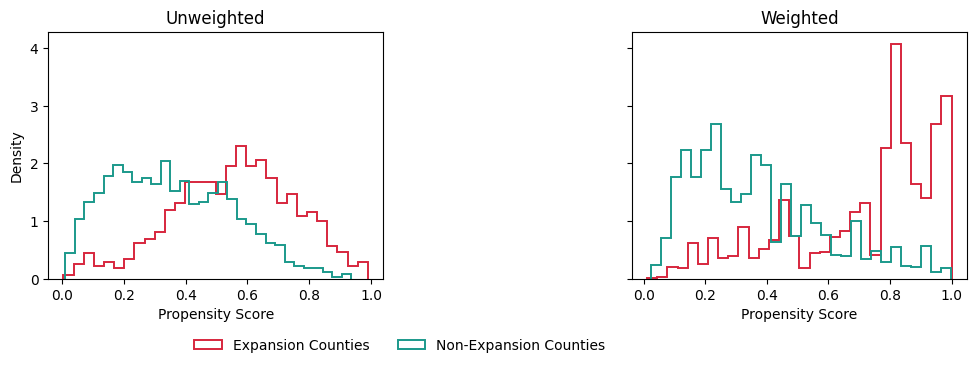

In [ ]:
# --- BEGIN FIGURE 1

plot_base = short_data[short_data["year"] == 2013].copy()
plot_base["pscore_unw"] = ps_unw.predict(plot_base)
plot_base["pscore_w"] = ps_w.predict(plot_base)

fig1, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
colors = {1: "#D7263D", 0: "#1B998B"}

for ax, col, title in zip(axes, ["pscore_unw", "pscore_w"], ["Unweighted", "Weighted"]):
    for treat_val, label in [(1, "Expansion Counties"), (0, "Non-Expansion Counties")]:
        subset = plot_base[plot_base["Treat"] == treat_val]
        weights_hist = subset["set_wt"] if col == "pscore_w" else None
        ax.hist(
            subset[col],
            bins=30,
            density=True,
            weights=weights_hist,
            histtype="step",
            linewidth=1.4,
            color=colors[treat_val],
            label=label,
        )
    ax.set_title(title)
    ax.set_xlabel("Propensity Score")
    ax.grid(False)

axes[0].set_ylabel("Density")
axes[0].legend(loc="lower center", bbox_to_anchor=(1.05, -0.35), ncol=2, frameon=False)
fig1.tight_layout()

if SHOW_OUTPUTS:
    display(fig1)
fig1_path = save_fig(fig1, "figure1_pscore.png")

# --- END FIGURE 1

## Figure 2: County Mortality Trends by Expansion Decision

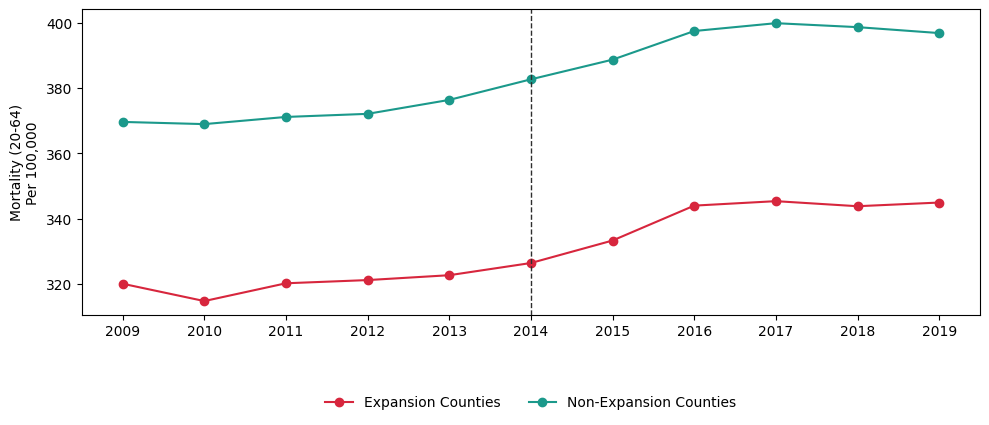

In [ ]:
# --- BEGIN FIGURE 2

trend_rows = []
for (treat, year), group in mydata.groupby(["Treat", "year"]):
    trend_rows.append(
        {
            "group": "Expansion Counties" if treat == 1 else "Non-Expansion Counties",
            "year": int(year),
            "mortality": weighted_mean(group["crude_rate_20_64"], group["set_wt"]),
        }
    )

trend = pd.DataFrame(trend_rows)

fig2, ax2 = plt.subplots(figsize=(10, 4.5))
colors2 = {"Expansion Counties": "#D7263D", "Non-Expansion Counties": "#1B998B"}
for group, gdf in trend.groupby("group"):
    ax2.plot(gdf["year"], gdf["mortality"], marker="o", color=colors2[group], label=group)
ax2.axvline(2014, linestyle="--", color="#2E2E2E", linewidth=1)
ax2.set_xlabel("")
ax2.set_ylabel("Mortality (20-64)\nPer 100,000")
ax2.set_xticks(range(2009, 2020))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2, frameon=False)
ax2.grid(False)
fig2.tight_layout()

if SHOW_OUTPUTS:
    display(fig2)
fig2_path = save_fig(fig2, "figure2_trends.png")

# --- END FIGURE 2

## Figure 3: 2xT Event Study



Overall summary of ATT's based on event-study/dynamic aggregation:
    ATT Std. Error  [95.0%  Conf. Int.] 
-0.7035       2.02 -4.6626       3.2556 


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Pointwise   Conf. Band  
0           -5    4.1292      2.6312            -1.0278      9.2862  
1           -4   -0.5017      2.0269            -4.4743      3.4709  
2           -3    2.7532      1.6160            -0.4141      5.9204  
3           -2    2.7805      1.5223            -0.2031      5.7641  
4           -1    0.0000         NaN                NaN         NaN  
5            0   -2.5629      1.4892            -5.4816      0.3558  
6            1   -1.6973      1.8381            -5.2999      1.9052  
7            2    0.2189      2.3304            -4.3486      4.7864  
8            3   -0.8133      2.7357            -6.1751      4.5485  
9            4   -1.1533      2.8010            -6.6431      4.3365  
10           5    1.7867      2.9306            -3.9571     

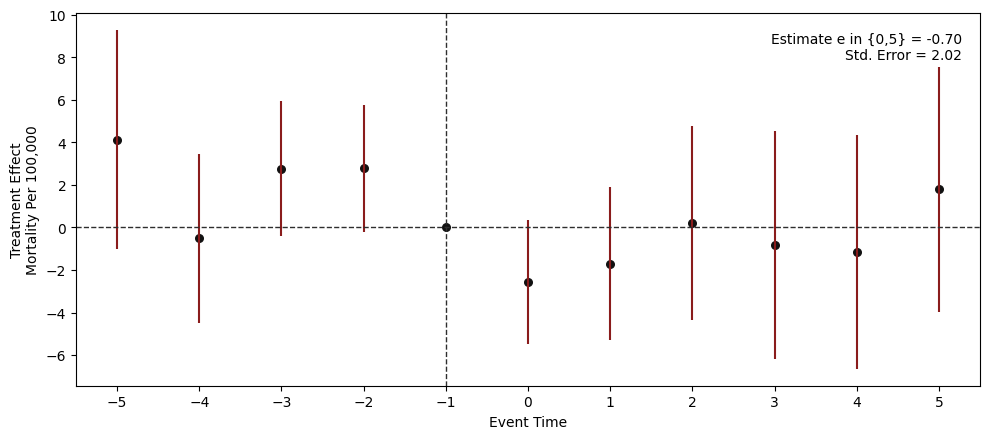

In [ ]:
# --- BEGIN FIGURE 3

event_data = mydata.copy()
event_data["treat_year"] = np.where((event_data["yaca"] == 2014) & (~event_data["yaca"].isna()), 2014, 0)
event_data["county_code"] = event_data["county_code"].astype(int)

# csdid: ATTgt estimates ATT(g,t) for event-study dynamics.
event_att = ATTgt(
    yname="crude_rate_20_64",
    tname="year",
    idname="county_code",
    gname="treat_year",
    data=event_data,
    control_group="nevertreated",
    xformla=None,
    panel=True,
    allow_unbalanced_panel=True,
    weights_name="set_wt",
    cband=True,
    biters=BITERS,
)

# csdid: fit ATTgt with outcome regression.
event_att.fit(est_method="reg", base_period="universal", bstrap=BOOTSTRAP)
try:
    # csdid: aggte aggregates ATT(g,t) into event-time effects.
    event_att.aggte(typec="dynamic", biters=BITERS, cband=True)
    agg_event = event_att.atte
except ValueError:
    print("Warning: aggte bootstrap failed; retrying with cband=False.")
    try:
        event_att.aggte(typec="dynamic", biters=BITERS, cband=False)
        agg_event = event_att.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
        event_att.aggte(typec="dynamic", biters=BITERS, cband=False, bstrap=False)
        agg_event = event_att.atte

crit_val = agg_event["crit_val_egt"] if agg_event["crit_val_egt"] is not None else norm.ppf(0.975)

plot_df = pd.DataFrame(
    {
        "event_time": agg_event["egt"],
        "estimate": agg_event["att_egt"],
        "se": np.asarray(agg_event["se_egt"]).flatten(),
        "crit": crit_val,
    }
)
plot_df["conf_low"] = plot_df["estimate"] - plot_df["crit"] * plot_df["se"]
plot_df["conf_high"] = plot_df["estimate"] + plot_df["crit"] * plot_df["se"]

try:
    # csdid: aggte with min_e/max_e for post-period aggregation.
    event_att.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=True)
    agg_post = event_att.atte
except ValueError:
    print("Warning: aggte bootstrap failed; retrying with cband=False.")
    try:
        event_att.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=False)
        agg_post = event_att.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
        event_att.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=False, bstrap=False)
        agg_post = event_att.atte
att_post = float(agg_post["overall_att"])
se_post = float(agg_post["overall_se"])

fig3, ax3 = plt.subplots(figsize=(10, 4.5))
ax3.vlines(plot_df["event_time"], plot_df["conf_low"], plot_df["conf_high"], color="#8A1C1C")
ax3.scatter(plot_df["event_time"], plot_df["estimate"], color="#111111", s=30)
ax3.axhline(0, linestyle="--", color="#2E2E2E", linewidth=1)
ax3.axvline(-1, linestyle="--", color="#2E2E2E", linewidth=1)
ax3.set_xlabel("Event Time")
ax3.set_ylabel("Treatment Effect\nMortality Per 100,000")
ax3.set_xticks(range(-5, 6))
note_text = f"Estimate e in {{0,5}} = {att_post:.2f}\nStd. Error = {se_post:.2f}"
ax3.text(
    0.98,
    0.95,
    note_text,
    transform=ax3.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=3.0),
)
ax3.grid(False)
fig3.tight_layout()

if SHOW_OUTPUTS:
    display(fig3)
fig3_path = save_fig(fig3, "figure3_event_study.png")

# --- END FIGURE 3

## Figure 4: 2xT Event Study with Covariates



Overall summary of ATT's based on event-study/dynamic aggregation:
   ATT Std. Error  [95.0%  Conf. Int.] 
0.4581     2.3585 -4.1646       5.0807 


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Pointwise   Conf. Band  
0           -5    1.5710      2.6955            -3.7121      6.8540  
1           -4   -2.9149      2.5582            -7.9289      2.0990  
2           -3    1.8713      2.2945            -2.6257      6.3683  
3           -2    2.6147      2.4890            -2.2636      7.4930  
4           -1    0.0000         NaN                NaN         NaN  
5            0   -3.4592      2.3768            -8.1177      1.1993  
6            1   -0.4335      2.6415            -5.6108      4.7437  
7            2    0.3153      2.8741            -5.3179      5.9485  
8            3    0.8375      3.1229            -5.2833      6.9582  
9            4    0.9166      3.4070            -5.7610      7.5943  
10           5    4.5717      3.4122            -2.1161     11

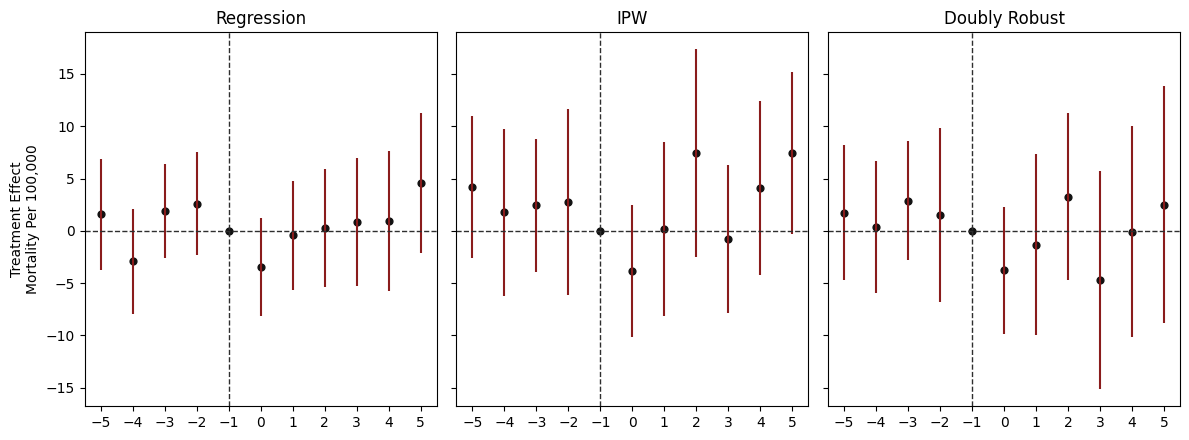

In [ ]:
# --- BEGIN FIGURE 4

methods = [("reg", "Regression"), ("ipw", "IPW"), ("dr", "Doubly Robust")]

fig4, axes4 = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

for ax4, (method, label) in zip(axes4, methods):
    # csdid: ATTgt estimates ATT(g,t) with covariates.
    cov_att = ATTgt(
        yname="crude_rate_20_64",
        tname="year",
        idname="county_code",
        gname="treat_year",
        data=event_data,
        control_group="nevertreated",
        xformla="~ " + " + ".join(COVS),
        panel=True,
        allow_unbalanced_panel=True,
        weights_name="set_wt",
        cband=True,
        biters=BITERS,
    )
    # csdid: fit ATTgt with covariates and selected estimator.
    cov_att.fit(est_method=method, base_period="universal", bstrap=BOOTSTRAP)
    try:
        # csdid: aggte aggregates to event-time effects.
        cov_att.aggte(typec="dynamic", biters=BITERS, cband=True)
        agg_cov = cov_att.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with cband=False.")
        try:
            cov_att.aggte(typec="dynamic", biters=BITERS, cband=False)
            agg_cov = cov_att.atte
        except ValueError:
            print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
            cov_att.aggte(typec="dynamic", biters=BITERS, cband=False, bstrap=False)
            agg_cov = cov_att.atte

    crit_val = agg_cov["crit_val_egt"] if agg_cov["crit_val_egt"] is not None else norm.ppf(0.975)

    plot_cov = pd.DataFrame(
        {
            "event_time": agg_cov["egt"],
            "estimate": agg_cov["att_egt"],
            "se": np.asarray(agg_cov["se_egt"]).flatten(),
            "crit": crit_val,
        }
    )
    plot_cov["conf_low"] = plot_cov["estimate"] - plot_cov["crit"] * plot_cov["se"]
    plot_cov["conf_high"] = plot_cov["estimate"] + plot_cov["crit"] * plot_cov["se"]

    ax4.vlines(plot_cov["event_time"], plot_cov["conf_low"], plot_cov["conf_high"], color="#8A1C1C")
    ax4.scatter(plot_cov["event_time"], plot_cov["estimate"], color="#111111", s=24)
    ax4.axhline(0, linestyle="--", color="#2E2E2E", linewidth=1)
    ax4.axvline(-1, linestyle="--", color="#2E2E2E", linewidth=1)
    ax4.set_title(label)
    ax4.set_xticks(range(-5, 6))
    ax4.grid(False)

axes4[0].set_ylabel("Treatment Effect\nMortality Per 100,000")
fig4.tight_layout()

if SHOW_OUTPUTS:
    display(fig4)
fig4_path = save_fig(fig4, "figure4_event_study_covariates.png")

# --- END FIGURE 4

## Figure 5: Mortality Trends by Expansion Timing

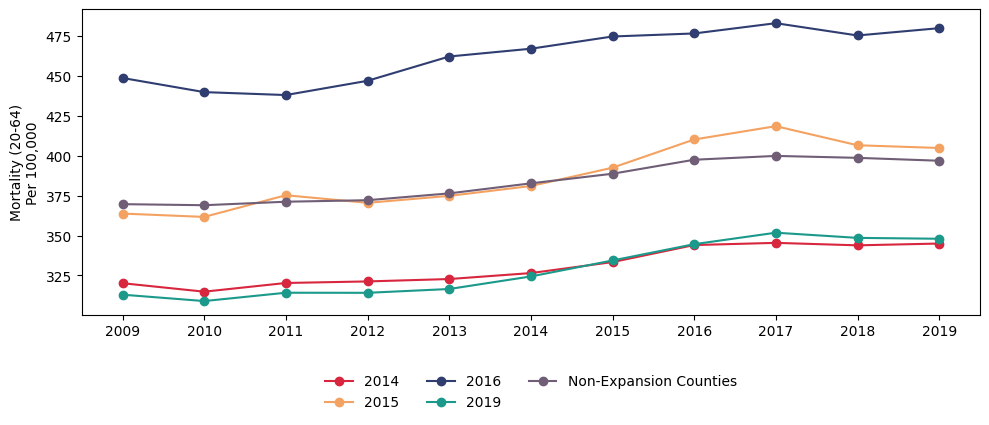

In [ ]:
# --- BEGIN FIGURE 5

staggered = df.copy()
staggered = staggered[~staggered["state"].isin(["DC", "DE", "MA", "NY", "VT"])].copy()

staggered = staggered.assign(
    perc_white=staggered["population_20_64_white"] / staggered["population_20_64"] * 100,
    perc_hispanic=staggered["population_20_64_hispanic"] / staggered["population_20_64"] * 100,
    perc_female=staggered["population_20_64_female"] / staggered["population_20_64"] * 100,
    unemp_rate=staggered["unemp_rate"] * 100,
    median_income=staggered["median_income"] / 1000,
)

staggered = staggered[
    [
        "state",
        "county",
        "county_code",
        "year",
        "population_20_64",
        "yaca",
        "crude_rate_20_64",
    ]
    + COVS
].copy()

staggered = staggered.dropna(subset=COVS + ["crude_rate_20_64", "population_20_64"]).copy()
staggered = staggered.groupby("county_code", group_keys=False).filter(
    lambda g: g["year"].isin([2013, 2014]).sum() == 2
)
staggered = staggered.groupby("county_code", group_keys=False).filter(lambda g: len(g) == 11).reset_index(drop=True)

staggered["Treat"] = np.where((~staggered["yaca"].isna()) & (staggered["yaca"] <= 2019), 1, 0)
staggered["treat_year"] = np.where((~staggered["yaca"].isna()) & (staggered["yaca"] <= 2019), staggered["yaca"], 0)

staggered_weights = (
    staggered[staggered["year"] == 2013][["county_code", "population_20_64"]]
    .drop_duplicates()
    .rename(columns={"population_20_64": "set_wt"})
)
staggered = staggered.merge(staggered_weights, on="county_code", how="left")

staggered["treat_label"] = staggered["treat_year"].apply(
    lambda x: "Non-Expansion Counties" if x == 0 else str(int(x))
)

trend_rows = []
for (group, year), gdf in staggered.groupby(["treat_label", "year"]):
    trend_rows.append(
        {
            "group": group,
            "year": int(year),
            "mortality": weighted_mean(gdf["crude_rate_20_64"], gdf["set_wt"]),
        }
    )
trend_gxt = pd.DataFrame(trend_rows)

colors5 = {
    "Non-Expansion Counties": "#6F5E76",
    "2014": "#D7263D",
    "2015": "#F4A261",
    "2016": "#2F3D70",
    "2019": "#1B998B",
}

fig5, ax5 = plt.subplots(figsize=(10, 4.5))
for group, gdf in trend_gxt.groupby("group"):
    ax5.plot(gdf["year"], gdf["mortality"], marker="o", color=colors5.get(group, "#444444"), label=group)
ax5.set_xlabel("")
ax5.set_ylabel("Mortality (20-64)\nPer 100,000")
ax5.set_xticks(range(2009, 2020))
ax5.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3, frameon=False)
ax5.grid(False)
fig5.tight_layout()

if SHOW_OUTPUTS:
    display(fig5)
fig5_path = save_fig(fig5, "figure5_staggered_trends.png")

# --- END FIGURE 5

## Figure 6: ATT(g,t) by Calendar Time

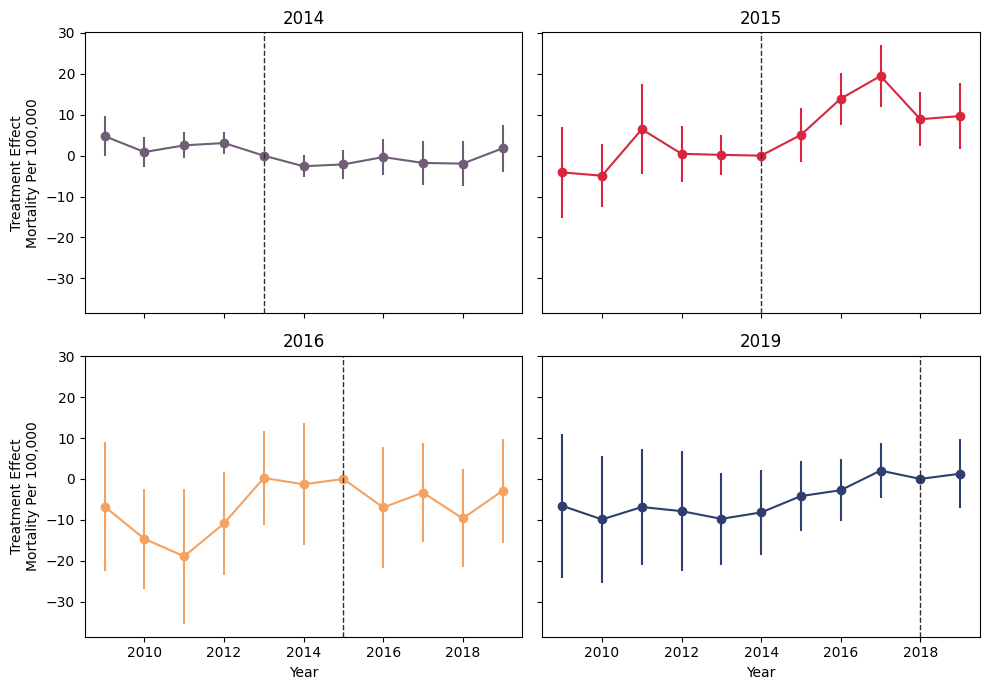

In [ ]:
# --- BEGIN FIGURE 6

staggered["county_code"] = staggered["county_code"].astype(int)

# csdid: ATTgt estimates ATT(g,t) using not-yet-treated controls.
att_no_x = ATTgt(
    yname="crude_rate_20_64",
    tname="year",
    idname="county_code",
    gname="treat_year",
    data=staggered,
    control_group="notyettreated",
    xformla=None,
    panel=True,
    allow_unbalanced_panel=True,
    weights_name="set_wt",
    cband=True,
    biters=BITERS,
)

# csdid: fit ATTgt with doubly robust estimator.
att_no_x.fit(est_method="dr", base_period="universal", bstrap=BOOTSTRAP)

att_df = pd.DataFrame(
    {
        "group": att_no_x.results["group"],
        "time": att_no_x.results["year"],
        "att": att_no_x.results["att"],
        "se": att_no_x.results["se"],
    }
)

fig6, axes6 = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True)
axes6 = axes6.ravel()
colors6 = ["#6F5E76", "#D7263D", "#F4A261", "#2F3D70"]

for ax6, group, color in zip(axes6, sorted(att_df["group"].unique()), colors6):
    gdf = att_df[att_df["group"] == group]
    ax6.plot(gdf["time"], gdf["att"], marker="o", color=color)
    ax6.vlines(gdf["time"], gdf["att"] - 1.96 * gdf["se"], gdf["att"] + 1.96 * gdf["se"], color=color)
    ax6.axvline(group - 1, linestyle="--", color="#2E2E2E", linewidth=1)
    ax6.set_title(str(int(group)))
    ax6.grid(False)

axes6[0].set_ylabel("Treatment Effect\nMortality Per 100,000")
axes6[2].set_ylabel("Treatment Effect\nMortality Per 100,000")
for ax6 in axes6[2:]:
    ax6.set_xlabel("Year")

fig6.tight_layout()

if SHOW_OUTPUTS:
    display(fig6)
fig6_path = save_fig(fig6, "figure6_attgt_calendar.png")

# --- END FIGURE 6

## Figure 7: ATT(g,t) in Event Time

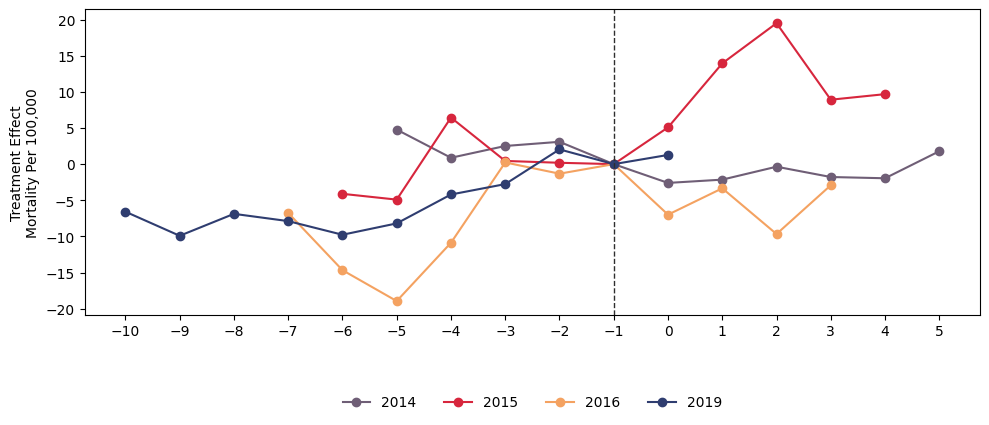

In [ ]:
# --- BEGIN FIGURE 7

att_df["event_time"] = att_df["time"] - att_df["group"]

fig7, ax7 = plt.subplots(figsize=(10, 4.5))
colors7 = {2014: "#6F5E76", 2015: "#D7263D", 2016: "#F4A261", 2019: "#2F3D70"}

for group, gdf in att_df.groupby("group"):
    ax7.plot(
        gdf["event_time"],
        gdf["att"],
        marker="o",
        color=colors7.get(group, "#444444"),
        label=str(int(group)),
    )

ax7.axvline(-1, linestyle="--", color="#2E2E2E", linewidth=1)
ax7.set_xlabel("")
ax7.set_ylabel("Treatment Effect\nMortality Per 100,000")
ax7.set_xticks(range(-10, 6))
ax7.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=4, frameon=False)
ax7.grid(False)
fig7.tight_layout()

if SHOW_OUTPUTS:
    display(fig7)
fig7_path = save_fig(fig7, "figure7_attgt_event.png")

# --- END FIGURE 7

## Figure 8: Event Study Without Covariates (GxT)



Overall summary of ATT's based on event-study/dynamic aggregation:
   ATT Std. Error  [95.0%  Conf. Int.] 
0.0868     1.8906 -3.6187       3.7922 


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Pointwise   Conf. Band   
0           -5    2.2187      2.1897            -2.0731      6.5105   
1           -4    0.8579      1.6237            -2.3244      4.0402   
2           -3    1.9161      1.3326            -0.6956      4.5279   
3           -2    2.5645      1.2186             0.1760      4.9529  *
4           -1    0.0000         NaN                NaN         NaN   
5            0   -1.6546      1.2084            -4.0230      0.7138   
6            1   -0.2616      1.6703            -3.5354      3.0121   
7            2    1.7056      2.1462            -2.5010      5.9121   
8            3   -0.5405      2.4669            -5.3755      4.2945   
9            4   -0.5149      2.6055            -5.6215      4.5917   
10           5    1.7867      2.9306            -3.

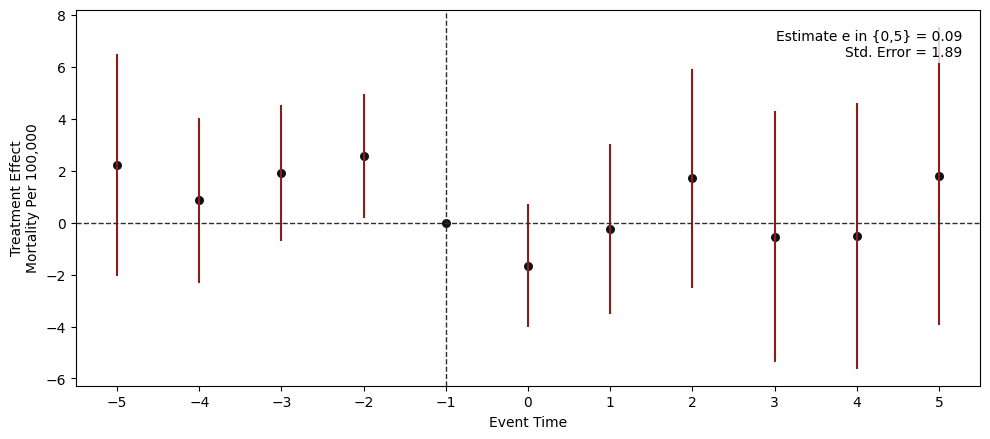

In [ ]:
# --- BEGIN FIGURE 8

try:
    # csdid: aggte aggregates ATT(g,t) into event-time effects.
    att_no_x.aggte(typec="dynamic", min_e=-5, max_e=5, biters=BITERS, cband=True)
    agg_no_x = att_no_x.atte
except ValueError:
    print("Warning: aggte bootstrap failed; retrying with cband=False.")
    try:
        att_no_x.aggte(typec="dynamic", min_e=-5, max_e=5, biters=BITERS, cband=False)
        agg_no_x = att_no_x.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
        att_no_x.aggte(typec="dynamic", min_e=-5, max_e=5, biters=BITERS, cband=False, bstrap=False)
        agg_no_x = att_no_x.atte
crit_val = agg_no_x["crit_val_egt"] if agg_no_x["crit_val_egt"] is not None else norm.ppf(0.975)

plot_no_x = pd.DataFrame(
    {
        "event_time": agg_no_x["egt"],
        "estimate": agg_no_x["att_egt"],
        "se": np.asarray(agg_no_x["se_egt"]).flatten(),
        "crit": crit_val,
    }
)
plot_no_x["conf_low"] = plot_no_x["estimate"] - plot_no_x["crit"] * plot_no_x["se"]
plot_no_x["conf_high"] = plot_no_x["estimate"] + plot_no_x["crit"] * plot_no_x["se"]

try:
    # csdid: aggte with min_e/max_e for post-period aggregation.
    att_no_x.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=True)
    agg_post = att_no_x.atte
except ValueError:
    print("Warning: aggte bootstrap failed; retrying with cband=False.")
    try:
        att_no_x.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=False)
        agg_post = att_no_x.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
        att_no_x.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=False, bstrap=False)
        agg_post = att_no_x.atte
att_post = float(agg_post["overall_att"])
se_post = float(agg_post["overall_se"])

fig8, ax8 = plt.subplots(figsize=(10, 4.5))
ax8.vlines(plot_no_x["event_time"], plot_no_x["conf_low"], plot_no_x["conf_high"], color="#8A1C1C")
ax8.scatter(plot_no_x["event_time"], plot_no_x["estimate"], color="#111111", s=30)
ax8.axhline(0, linestyle="--", color="#2E2E2E", linewidth=1)
ax8.axvline(-1, linestyle="--", color="#2E2E2E", linewidth=1)
ax8.set_xlabel("Event Time")
ax8.set_ylabel("Treatment Effect\nMortality Per 100,000")
ax8.set_xticks(range(-5, 6))
note_text = f"Estimate e in {{0,5}} = {att_post:.2f}\nStd. Error = {se_post:.2f}"
ax8.text(
    0.98,
    0.95,
    note_text,
    transform=ax8.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=3.0),
)
ax8.grid(False)
fig8.tight_layout()

if SHOW_OUTPUTS:
    display(fig8)
fig8_path = save_fig(fig8, "figure8_event_no_covs.png")

# --- END FIGURE 8

## Figure 9: Event Study With Covariates (GxT)



Overall summary of ATT's based on event-study/dynamic aggregation:
   ATT Std. Error   [95.0%  Conf. Int.] 
-2.247     4.0007 -10.0882       5.5942 


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Pointwise   Conf. Band  
0           -5    2.6685      2.2836            -1.8072      7.1442  
1           -4    2.1334      2.5961            -2.9549      7.2216  
2           -3    2.8574      1.9456            -0.9559      6.6708  
3           -2    2.9130      2.7147            -2.4077      8.2337  
4           -1    0.0000         NaN                NaN         NaN  
5            0   -1.4930      2.6803            -6.7462      3.7603  
6            1   -1.9694      3.6887            -9.1990      5.2602  
7            2   -2.7251      5.1761           -12.8701      7.4200  
8            3   -5.0557      5.0759           -15.0042      4.8929  
9            4   -4.7162      6.1195           -16.7102      7.2779  
10           5    2.4772      5.7773            -8.8461     

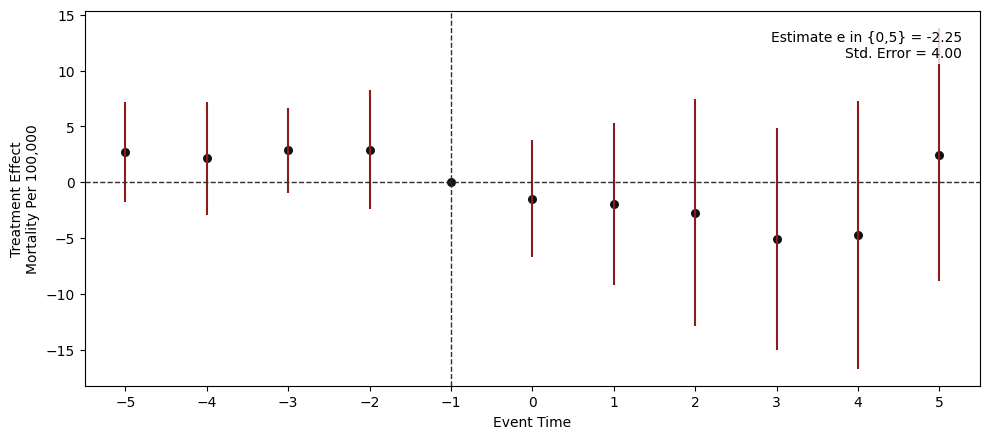

In [ ]:
# --- BEGIN FIGURE 9

# csdid: ATTgt estimates ATT(g,t) with covariates and not-yet-treated controls.
att_with_x = ATTgt(
    yname="crude_rate_20_64",
    tname="year",
    idname="county_code",
    gname="treat_year",
    data=staggered,
    control_group="notyettreated",
    xformla="~ " + " + ".join(COVS),
    panel=True,
    allow_unbalanced_panel=True,
    weights_name="set_wt",
    cband=True,
    biters=BITERS,
)

# csdid: fit ATTgt with doubly robust estimator and covariates.
att_with_x.fit(est_method="dr", base_period="universal", bstrap=BOOTSTRAP)

try:
    # csdid: aggte aggregates ATT(g,t) into event-time effects.
    att_with_x.aggte(typec="dynamic", min_e=-5, max_e=5, biters=BITERS, cband=True)
    agg_with_x = att_with_x.atte
except ValueError:
    print("Warning: aggte bootstrap failed; retrying with cband=False.")
    try:
        att_with_x.aggte(typec="dynamic", min_e=-5, max_e=5, biters=BITERS, cband=False)
        agg_with_x = att_with_x.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
        att_with_x.aggte(typec="dynamic", min_e=-5, max_e=5, biters=BITERS, cband=False, bstrap=False)
        agg_with_x = att_with_x.atte
crit_val = agg_with_x["crit_val_egt"] if agg_with_x["crit_val_egt"] is not None else norm.ppf(0.975)

plot_with_x = pd.DataFrame(
    {
        "event_time": agg_with_x["egt"],
        "estimate": agg_with_x["att_egt"],
        "se": np.asarray(agg_with_x["se_egt"]).flatten(),
        "crit": crit_val,
    }
)
plot_with_x["conf_low"] = plot_with_x["estimate"] - plot_with_x["crit"] * plot_with_x["se"]
plot_with_x["conf_high"] = plot_with_x["estimate"] + plot_with_x["crit"] * plot_with_x["se"]

try:
    # csdid: aggte with min_e/max_e for post-period aggregation.
    att_with_x.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=True)
    agg_post = att_with_x.atte
except ValueError:
    print("Warning: aggte bootstrap failed; retrying with cband=False.")
    try:
        att_with_x.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=False)
        agg_post = att_with_x.atte
    except ValueError:
        print("Warning: aggte bootstrap failed; retrying with bstrap=False.")
        att_with_x.aggte(typec="dynamic", min_e=0, max_e=5, biters=BITERS, cband=False, bstrap=False)
        agg_post = att_with_x.atte
att_post = float(agg_post["overall_att"])
se_post = float(agg_post["overall_se"])

fig9, ax9 = plt.subplots(figsize=(10, 4.5))
ax9.vlines(plot_with_x["event_time"], plot_with_x["conf_low"], plot_with_x["conf_high"], color="#8A1C1C")
ax9.scatter(plot_with_x["event_time"], plot_with_x["estimate"], color="#111111", s=30)
ax9.axhline(0, linestyle="--", color="#2E2E2E", linewidth=1)
ax9.axvline(-1, linestyle="--", color="#2E2E2E", linewidth=1)
ax9.set_xlabel("Event Time")
ax9.set_ylabel("Treatment Effect\nMortality Per 100,000")
ax9.set_xticks(range(-5, 6))
note_text = f"Estimate e in {{0,5}} = {att_post:.2f}\nStd. Error = {se_post:.2f}"
ax9.text(
    0.98,
    0.95,
    note_text,
    transform=ax9.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=3.0),
)
ax9.grid(False)
fig9.tight_layout()

if SHOW_OUTPUTS:
    display(fig9)
fig9_path = save_fig(fig9, "figure9_event_covs.png")

# --- END FIGURE 9

## HTML report

In [ ]:
def strip_helper_functions(code: str, names: set[str]) -> str:
    lines = code.splitlines()
    kept = []
    skip = False
    for line in lines:
        if not skip:
            if line.startswith("def "):
                func_name = line.split("def ", 1)[1].split("(", 1)[0]
                if func_name in names:
                    skip = True
                    continue
            kept.append(line)
        else:
            if line.strip() == "":
                skip = False
                kept.append(line)
    cleaned = "\n".join(kept).strip()
    while "\n\n\n" in cleaned:
        cleaned = cleaned.replace("\n\n\n", "\n\n")
    return cleaned


script_path = Path(__file__).resolve() if "__file__" in globals() else ROOT / "python_replication_jupytext.py"
if not script_path.exists():
    script_path = ROOT / "python_replication.py"
source_text = script_path.read_text(encoding="utf-8")

install_code = (
    "# Install latest csdid from GitHub\n"
    "# !pip install -U git+https://github.com/d2cml-ai/csdid\n"
)
helpers_start = source_text.find("def weighted_mean")
helpers_end = source_text.find("# %% [markdown]\n# ## Load data", helpers_start)
helpers_code = ""
if helpers_start != -1 and helpers_end != -1:
    helpers_code = source_text[helpers_start:helpers_end].rstrip()
    helpers_code = strip_helper_functions(
        helpers_code,
        {"df_to_html_table", "encode_fig", "extract_block", "section_html"},
    )
setup_code = f"{install_code}\n{helpers_code}".strip()

code_blocks = {
    "setup": setup_code,
    "table1": extract_block(source_text, "TABLE 1"),
    "table2": extract_block(source_text, "TABLE 2"),
    "table3": extract_block(source_text, "TABLE 3"),
    "table4": extract_block(source_text, "TABLE 4"),
    "table5": extract_block(source_text, "TABLE 5"),
    "table6": extract_block(source_text, "TABLE 6"),
    "table7": extract_block(source_text, "TABLE 7"),
    "figure1": extract_block(source_text, "FIGURE 1"),
    "figure2": extract_block(source_text, "FIGURE 2"),
    "figure3": extract_block(source_text, "FIGURE 3"),
    "figure4": extract_block(source_text, "FIGURE 4"),
    "figure5": extract_block(source_text, "FIGURE 5"),
    "figure6": extract_block(source_text, "FIGURE 6"),
    "figure7": extract_block(source_text, "FIGURE 7"),
    "figure8": extract_block(source_text, "FIGURE 8"),
    "figure9": extract_block(source_text, "FIGURE 9"),
}

sections = [
    {
        "id": "setup",
        "title": "Setup: Install Package and Helpers",
        "description": "Install the latest csdid package and define helper utilities used below.",
        "body": "",
        "code": code_blocks["setup"],
    },
    {
        "id": "table1",
        "title": "Table 1: Medicaid Expansion Adoption",
        "description": "Roll-out of Medicaid expansion under the ACA across states.",
        "body": df_to_html_table(table1),
        "code": code_blocks["table1"],
    },
    {
        "id": "table2",
        "title": "Table 2: Simple 2x2 DiD",
        "description": "Simple 2x2 DiD using 2013 vs 2014, expansion vs non-expansion.",
        "body": df_to_html_table(table2),
        "code": code_blocks["table2"],
    },
    {
        "id": "table3",
        "title": "Table 3: Regression DiD",
        "description": "Regression-based 2x2 DiD estimates with and without fixed effects.",
        "body": df_to_html_table(table3),
        "code": code_blocks["table3"],
    },
    {
        "id": "table4",
        "title": "Table 4: Covariate Balance",
        "description": "Balance checks for covariates in levels and 2014-2013 differences.",
        "body": df_to_html_table(table4),
        "code": code_blocks["table4"],
    },
    {
        "id": "table5",
        "title": "Table 5: Regression 2x2 DiD with Covariates",
        "description": "Long-difference regressions with covariates in levels or changes.",
        "body": df_to_html_table(table5),
        "code": code_blocks["table5"],
    },
    {
        "id": "table6",
        "title": "Table 6: Outcome Regression and Propensity Score Models",
        "description": "Outcome regression and propensity score models for doubly robust DiD.",
        "body": df_to_html_table(table6),
        "code": code_blocks["table6"],
    },
    {
        "id": "table7",
        "title": "Table 7: Callaway and Sant'Anna (2021) DiD",
        "description": "Outcome regression, IPW, and doubly robust estimates from csdid.",
        "body": df_to_html_table(table7),
        "code": code_blocks["table7"],
    },
    {
        "id": "figure1",
        "title": "Figure 1: Distribution of Propensity Scores",
        "description": "Histogram of propensity scores for expansion vs non-expansion counties.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig1_path)}\" alt=\"Figure 1\"></div>",
        "code": code_blocks["figure1"],
    },
    {
        "id": "figure2",
        "title": "Figure 2: County Mortality Trends by Expansion Decision",
        "description": "Weighted mortality trends for 2014 expansion vs non-expansion counties.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig2_path)}\" alt=\"Figure 2\"></div>",
        "code": code_blocks["figure2"],
    },
    {
        "id": "figure3",
        "title": "Figure 3: 2xT Event Study",
        "description": "Event study without covariates using csdid (regression adjustment).",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig3_path)}\" alt=\"Figure 3\"></div>",
        "code": code_blocks["figure3"],
    },
    {
        "id": "figure4",
        "title": "Figure 4: 2xT Event Study with Covariates",
        "description": "Event studies with covariates using RA, IPW, and DR estimators.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig4_path)}\" alt=\"Figure 4\"></div>",
        "code": code_blocks["figure4"],
    },
    {
        "id": "figure5",
        "title": "Figure 5: Mortality Trends by Expansion Timing",
        "description": "Weighted mortality trends by treatment timing group (staggered adoption).",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig5_path)}\" alt=\"Figure 5\"></div>",
        "code": code_blocks["figure5"],
    },
    {
        "id": "figure6",
        "title": "Figure 6: ATT(g,t) by Calendar Time",
        "description": "Cohort-specific treatment effects over calendar time.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig6_path)}\" alt=\"Figure 6\"></div>",
        "code": code_blocks["figure6"],
    },
    {
        "id": "figure7",
        "title": "Figure 7: ATT(g,t) in Event Time",
        "description": "ATT(g,t) stacked in relative/event time by cohort.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig7_path)}\" alt=\"Figure 7\"></div>",
        "code": code_blocks["figure7"],
    },
    {
        "id": "figure8",
        "title": "Figure 8: GxT Event Study Without Covariates",
        "description": "Event study using not-yet-treated controls, no covariates.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig8_path)}\" alt=\"Figure 8\"></div>",
        "code": code_blocks["figure8"],
    },
    {
        "id": "figure9",
        "title": "Figure 9: GxT Event Study With Covariates",
        "description": "Event study with covariates using the doubly robust estimator.",
        "body": f"<div class=\"figure\"><img src=\"{encode_fig(fig9_path)}\" alt=\"Figure 9\"></div>",
        "code": code_blocks["figure9"],
    },
]

sections_html = "\n".join(
    section_html(section["id"], section["title"], section["description"], section["body"], section["code"])
    for section in sections
)

csdid_version_str = getattr(csdid_version, "__version", "unknown")

nav_items = [
    ("intro", "Introduction"),
    ("setup", "Setup"),
    ("table1", "Table 1"),
    ("table2", "Table 2"),
    ("table3", "Table 3"),
    ("table4", "Table 4"),
    ("table5", "Table 5"),
    ("table6", "Table 6"),
    ("table7", "Table 7"),
    ("figure1", "Figure 1"),
    ("figure2", "Figure 2"),
    ("figure3", "Figure 3"),
    ("figure4", "Figure 4"),
    ("figure5", "Figure 5"),
    ("figure6", "Figure 6"),
    ("figure7", "Figure 7"),
    ("figure8", "Figure 8"),
    ("figure9", "Figure 9"),
]

nav_html = "\n".join(f"<a href=\"#{item_id}\">{label}</a>" for item_id, label in nav_items)

html_output = f"""<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>Replication: JEL-DiD (Python)</title>
  <style>
    :root {{
      --ink: #1D1C1A;
      --accent: #D7263D;
      --accent-2: #1B998B;
      --accent-3: #F4A261;
      --paper: #F9F6F1;
      --card: #FFFFFF;
      --muted: #6B645C;
      --shadow: 0 12px 30px rgba(29, 28, 26, 0.12);
    }}

    * {{ box-sizing: border-box; }}

    body {{
      margin: 0;
      font-family: "Spectral", "Times New Roman", serif;
      color: var(--ink);
      background: radial-gradient(circle at top, #F4EDE2 0%, #F9F6F1 55%, #EFE8DD 100%);
    }}

    .layout {{
      display: grid;
      grid-template-columns: 260px 1fr;
      gap: 24px;
      max-width: 1200px;
      margin: 24px auto 80px;
      padding: 0 24px;
    }}

    nav {{
      position: sticky;
      top: 24px;
      align-self: start;
      background: rgba(255, 255, 255, 0.95);
      border: 1px solid #E5DCCF;
      border-radius: 16px;
      padding: 18px;
      box-shadow: var(--shadow);
    }}

    nav h2 {{
      font-size: 18px;
      margin: 0 0 12px;
      text-transform: uppercase;
      letter-spacing: 1px;
      color: var(--accent);
      font-family: "Fira Sans", "Helvetica", sans-serif;
    }}

    nav a {{
      display: block;
      color: var(--ink);
      text-decoration: none;
      margin: 8px 0;
      font-family: "Fira Sans", "Helvetica", sans-serif;
      font-size: 14px;
    }}

    nav a:hover {{
      color: var(--accent);
    }}

    header {{
      grid-column: 1 / -1;
      background: var(--card);
      border-radius: 24px;
      padding: 28px 32px;
      box-shadow: var(--shadow);
      animation: rise 0.8s ease;
    }}

    header h1 {{
      margin: 0;
      font-size: 34px;
      letter-spacing: 0.5px;
    }}

    header p {{
      margin: 10px 0 0;
      color: var(--muted);
      font-family: "Fira Sans", "Helvetica", sans-serif;
    }}

    section {{
      background: var(--card);
      border-radius: 20px;
      padding: 24px 28px;
      box-shadow: var(--shadow);
      margin-bottom: 24px;
      animation: fadeIn 0.8s ease;
    }}

    section h2 {{
      margin-top: 0;
      font-size: 24px;
      color: var(--accent);
      font-family: "Fira Sans", "Helvetica", sans-serif;
    }}

    .output {{
      margin-top: 18px;
      overflow-x: auto;
    }}

    table.data {{
      border-collapse: collapse;
      width: 100%;
      font-family: "Fira Sans", "Helvetica", sans-serif;
      font-size: 14px;
    }}

    table.data thead th {{
      background: var(--accent);
      color: white;
      padding: 10px;
      text-align: left;
    }}

    table.data tbody td {{
      border-bottom: 1px solid #EEE6DA;
      padding: 8px 10px;
    }}

    table.data tbody tr:nth-child(even) {{
      background: #FBF7F2;
    }}

    .se {{
      color: var(--muted);
      font-size: 12px;
    }}

    .code-block {{
      margin-top: 16px;
    }}

    pre {{
      margin: 0;
      padding: 12px;
      background: #14110F;
      color: #F5EFE6;
      border-radius: 12px;
      overflow-x: auto;
      font-size: 12px;
    }}

    .figure img {{
      width: 100%;
      border-radius: 16px;
      border: 1px solid #EEE6DA;
    }}

    .tag {{
      display: inline-block;
      padding: 4px 10px;
      border-radius: 999px;
      background: var(--accent-2);
      color: white;
      font-size: 12px;
      font-family: "Fira Sans", "Helvetica", sans-serif;
      letter-spacing: 0.4px;
      margin-bottom: 8px;
    }}

    @keyframes fadeIn {{
      from {{ opacity: 0; transform: translateY(12px); }}
      to {{ opacity: 1; transform: translateY(0); }}
    }}

    @keyframes rise {{
      from {{ opacity: 0; transform: translateY(20px); }}
      to {{ opacity: 1; transform: translateY(0); }}
    }}

    @media (max-width: 900px) {{
      .layout {{
        grid-template-columns: 1fr;
      }}

      nav {{
        position: relative;
      }}
    }}
  </style>
</head>
<body>
  <div class="layout">
    <header id="top">
      <h1>Code for Replication in Python - csdid</h1>
      <p>Tables and figures generated from the ACA Medicaid expansion dataset. Author: Gabriel Saco</p>
    </header>

    <nav>
      <h2>Contents</h2>
      {nav_html}
    </nav>

    <main>
      <section id="intro">
        <span class="tag">Introduction</span>
        <h2>Introduction</h2>
        <p>
          This appendix reproduces the tables and figures for the JEL-DiD replication
          using Python and the csdid package. Each section follows the same workflow
          as the R/Stata reference, with outputs rendered below.
        </p>
      </section>

      {sections_html}
    </main>
  </div>
</body>
</html>
"""

HTML_PATH.write_text(html_output, encoding="utf-8")

803145